In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os
import scipy.io
import copy

In [2]:
adv_robust_root_path = os.path.join("..", "adv_robust")
import sys
# include parent dir in the python search path
sys.path.append(adv_robust_root_path)
import fig_utils as u
import gllim

In [3]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [12]:
# load data, normal and adv images

data_root_path = os.path.join(adv_robust_root_path, "tf_autozoom_2d_randVec20")
data_path = os.path.join(data_root_path, "all_results.pkl")
with open(data_path, "rb") as f:
    d = pickle.load(f)
true_train_x = d["true_x"]
true_train_y = d["true_y"]
adv_train_x = d["adv_x"]


# read in adversarial results for testing data
data_path = os.path.join(data_root_path, "all_test_results.pkl")
with open(data_path, "rb") as f:
    d = pickle.load(f)
true_test_x = d["true_x"]
true_test_y = d["true_y"]
adv_test_x = d["adv_x"]


# load corrupted images
with open(os.path.join(adv_robust_root_path, "corrupt_img", "test_corrupt_img.pkl"), "rb") as f:
    corrupted_test_x = pickle.load(f)
with open(os.path.join(adv_robust_root_path, "corrupt_img", "test_corrupt_region.pkl"), "rb") as f:
    corrupted_test_region = pickle.load(f)
with open(os.path.join(adv_robust_root_path, "corrupt_img", "test_rec_img.pkl"), "rb") as f:
    rec_test_x = pickle.load(f)
    
d = scipy.io.loadmat(os.path.join(adv_robust_root_path, "corrupt_img", "corrupt_img.mat"))
corrupted_train_x = d["train_corrupt_img"]

In [13]:
def transform_data(d, img_dim=32):
    n = d.shape[1]
    return np.transpose(copy.deepcopy(d)).reshape([n, 32, 32, 1])

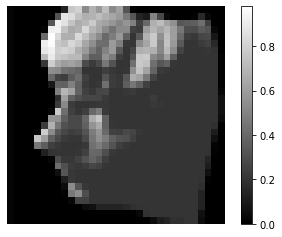

In [14]:
temp = transform_data(true_test_x)
u.plot_img(temp[1, :, :, 0].squeeze())

In [88]:
# all_train_data = np.hstack([true_train_x, adv_train_x, corrupted_train_x])
all_train_data = np.hstack([true_train_x, adv_train_x])
all_train_label = np.concatenate((np.zeros(598), np.ones(598)))
all_train_y = np.hstack([true_train_x, true_train_x])
# all_train_data = transform_data(all_train_data)

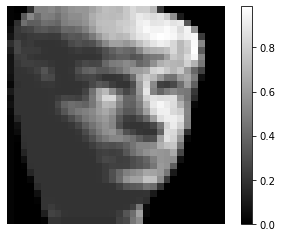

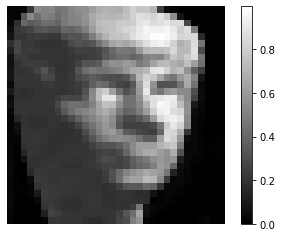

In [20]:
u.plot_img(all_train_data[1, :, :, 0].squeeze())
u.plot_img(all_train_data[1+598, :, :, 0].squeeze())

In [44]:
model = gllim.GLLiM_np(os.path.join(adv_robust_root_path, "test_code", "face_model.mat"))
Lt = 3
model.layers = [] # just for integrating the code
model.set_Lt(Lt)
model.get_ths()

[GLLiM] Numpy version
[GLLiM] load model: ..\adv_robust\test_code\face_model.mat
[GLLiM] parameters: K: 20, L: 12, cstr.Sigma: i*
[GLLiM] set Lt: 3


In [32]:
from detections.base import DetectionEvaluator

In [33]:
result_folder_detection = os.path.join("results", "detection")
csv_fname = "detection.csv"
de = DetectionEvaluator(model, result_folder_detection, csv_fname, "Face")

In [72]:
params_str = "FeatureSqueezing?squeezers=bit_depth_8&distance_measure=l2&fpr=0.05"
detector_name = [ele.strip() for ele in params_str.split(';') if ele.strip()!= '']
detector = de.get_detector_by_name(detector_name[0])

{'squeezers': 'bit_depth_8', 'distance_measure': 'l2', 'fpr': 0.05}


In [73]:
from detections.feature_squeezing import FeatureSqueezingDetector
fs_detector = FeatureSqueezingDetector(model, params_str)
fs_detector.get_distance(temp)

{'squeezers': 'bit_depth_8', 'distance_measure': 'l2', 'fpr': 0.05}


NameError: name 'Model' is not defined

In [74]:
fs_detector.get_config()

(-1, 'none', 'l2', ['bit_depth_8'])

In [75]:
squeezer = fs_detector.get_squeezer_by_name(fs_detector.get_config()[3][0])

In [76]:
target_index = 1
target_image = all_train_data[1+598, :, :, :]
squeeze_image = squeezer(target_image)

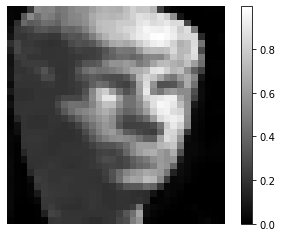

In [77]:
u.plot_img(squeeze_image.squeeze())

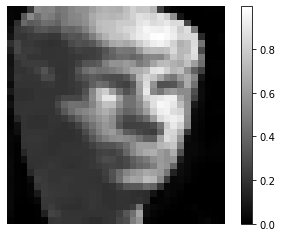

In [78]:
squeeze_image = squeezer(all_train_data)
u.plot_img(squeeze_image[1+598, :, :, 0].squeeze())

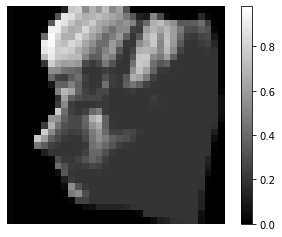

In [81]:
squeeze_image = squeezer(true_test_x)
u.plot_img(squeeze_image[:, 1])

# Try on different bit depth

In [ ]:
from detections.feature_squeezing import FeatureSqueezingDetector

In [105]:
bit_depth = 4
params_str = "FeatureSqueezing?squeezers=bit_depth_{}&distance_measure=l2&fpr=0.05".format(bit_depth)


fs_detector = FeatureSqueezingDetector(model, params_str)
squeezer = fs_detector.get_squeezer_by_name(fs_detector.get_config()[3][0])

{'squeezers': 'bit_depth_4', 'distance_measure': 'l2', 'fpr': 0.05}


In [106]:
squeeze_x = squeezer(all_train_data)
pred_orig, _, _ = model.predict(all_train_data)
pred_squeeze, _, _ = model.predict(squeeze_x)

In [107]:
pred_sse = np.sum((pred_orig - pred_squeeze)**2, axis=0)

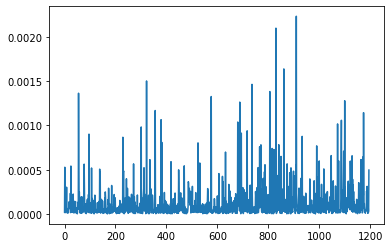

In [108]:
plt.plot(pred_sse)

In [177]:
from sklearn.preprocessing import normalize

In [178]:
def get_squeezer(param, squeezer_type="bit_depth"):
    if squeezer_type == "bit_depth":
        params_str = "FeatureSqueezing?squeezers=bit_depth_{}&distance_measure=l2&fpr=0.05".format(param)
    elif squeezer_type == "median_filter":
        params_str = "FeatureSqueezing?squeezers=median_filter_{}&distance_measure=l2&fpr=0.05".format(param)
    else:
        raise Exception("unknown squeezer type")
    fs_detector = FeatureSqueezingDetector(model, params_str)
    squeezer = fs_detector.get_squeezer_by_name(fs_detector.get_config()[3][0])
    return squeezer
    

def get_squeeze_difference(normal_x, squeezer):
    normal_x = copy.deepcopy(normal_x)
    pred_orig, _, _ = model.predict(normal_x)
    
    n = normal_x.shape[1]
    normal_x = np.transpose(normal_x)
    normal_x = np.reshape(normal_x, [n, 32, 32, 1])
    squeeze_x = squeezer(normal_x)
    
    squeeze_x = np.reshape(squeeze_x, [n, 1024])
    squeeze_x = np.transpose(squeeze_x)
    
    pred_squeeze, _, _ = model.predict(squeeze_x)
#     norm_orig = scipy.special.softmax(pred_orig, axis=0)
#     norm_squeeze = scipy.special.softmax(pred_squeeze, axis=0)
    norm_orig = normalize(pred_orig, axis=0)
    norm_squeeze = normalize(pred_squeeze, axis=0)
    
    return np.sum((norm_orig - norm_squeeze)**2, axis=0)
    

In [140]:
fpr = 0.05

bit_depth = 4
squeezer = get_squeezer(bit_depth)
train_normal_sse = get_squeeze_difference(true_train_x, squeezer)
threshold = np.quantile(train_normal_sse, 1 - fpr)
print("Bit depth: {}, fpr: {}, threshold: {}".format(bit_depth, fpr, threshold))

{'squeezers': 'bit_depth_4', 'distance_measure': 'l2', 'fpr': 0.05}
Bit depth: 4, fpr: 0.05, threshold: 0.00032572461114181467


In [114]:
test_normal_sse = get_squeeze_difference(true_test_x, squeezer)
test_adv_sse = get_squeeze_difference(adv_test_x, squeezer)

In [119]:
test_normal_correct = len(np.where(test_normal_sse < threshold)[0])
test_normal_wrong = len(np.where(test_normal_sse >= threshold)[0])

test_adv_correct = len(np.where(test_adv_sse >= threshold)[0])
test_adv_wrong = len(np.where(test_adv_sse < threshold)[0])

print("Normal: correct: {}, wrong: {}".format(test_normal_correct, test_normal_wrong))
print("Adv: correct: {}, wrong: {}".format(test_adv_correct, test_adv_wrong))

Normal: correct: 94, wrong: 6
Adv: correct: 16, wrong: 84


In [122]:

for bit_depth in [1, 2, 3, 4, 5, 6, 7, 8]:
    squeezer = get_squeezer(bit_depth)
    train_normal_sse = get_squeeze_difference(true_train_x, squeezer)
    threshold = np.quantile(train_normal_sse, 1 - fpr)
    print("Bit depth: {}, fpr: {}, threshold: {}".format(bit_depth, fpr, threshold))
    test_normal_sse = get_squeeze_difference(true_test_x, squeezer)
    test_adv_sse = get_squeeze_difference(adv_test_x, squeezer)
    test_normal_correct = len(np.where(test_normal_sse < threshold)[0])
    test_normal_wrong = len(np.where(test_normal_sse >= threshold)[0])

    test_adv_correct = len(np.where(test_adv_sse >= threshold)[0])
    test_adv_wrong = len(np.where(test_adv_sse < threshold)[0])

    print("Normal: correct: {}, wrong: {}".format(test_normal_correct, test_normal_wrong))
    print("Adv: correct: {}, wrong: {}".format(test_adv_correct, test_adv_wrong))
    print("")

{'squeezers': 'bit_depth_1', 'distance_measure': 'l2', 'fpr': 0.05}
Bit depth: 1, fpr: 0.05, threshold: 1.2180516505476389
Normal: correct: 92, wrong: 8
Adv: correct: 10, wrong: 90

{'squeezers': 'bit_depth_2', 'distance_measure': 'l2', 'fpr': 0.05}
Bit depth: 2, fpr: 0.05, threshold: 0.21197760156556517
Normal: correct: 94, wrong: 6
Adv: correct: 4, wrong: 96

{'squeezers': 'bit_depth_3', 'distance_measure': 'l2', 'fpr': 0.05}
Bit depth: 3, fpr: 0.05, threshold: 0.027006883731498243
Normal: correct: 93, wrong: 7
Adv: correct: 1, wrong: 99

{'squeezers': 'bit_depth_4', 'distance_measure': 'l2', 'fpr': 0.05}
Bit depth: 4, fpr: 0.05, threshold: 0.00032572461114181467
Normal: correct: 94, wrong: 6
Adv: correct: 16, wrong: 84

{'squeezers': 'bit_depth_5', 'distance_measure': 'l2', 'fpr': 0.05}
Bit depth: 5, fpr: 0.05, threshold: 0.00042611678119482805
Normal: correct: 95, wrong: 5
Adv: correct: 1, wrong: 99

{'squeezers': 'bit_depth_6', 'distance_measure': 'l2', 'fpr': 0.05}
Bit depth: 6, 

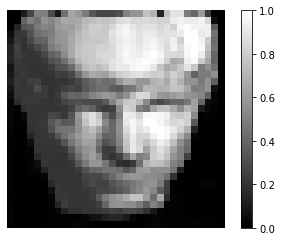

In [132]:
target_index = 6
target_adv_x = adv_test_x[:, target_index]
target_y = true_test_y[:, target_index]
target_x = true_test_x[:, target_index]
u.plot_img(target_adv_x)

In [129]:
adv_pred, _, _ = model.predict(target_adv_x[:, None])
adv_pred_sse = np.sum((adv_pred - target_y)**2)
print("Adv pred sse: {}".format(adv_pred_sse))

Adv pred sse: 0.32848346765820713


{'squeezers': 'bit_depth_1', 'distance_measure': 'l2', 'fpr': 0.05}
Bit depth:1, true sse: 0.7734842627571751, adv sse: 0.04009824193075058
{'squeezers': 'bit_depth_2', 'distance_measure': 'l2', 'fpr': 0.05}
Bit depth:2, true sse: 0.431415022921715, adv sse: 0.0050404387966991706
{'squeezers': 'bit_depth_3', 'distance_measure': 'l2', 'fpr': 0.05}
Bit depth:3, true sse: 0.325495892821857, adv sse: 8.923946586644665e-05
{'squeezers': 'bit_depth_4', 'distance_measure': 'l2', 'fpr': 0.05}
Bit depth:4, true sse: 0.3304556936597785, adv sse: 1.3658816699235494e-05
{'squeezers': 'bit_depth_5', 'distance_measure': 'l2', 'fpr': 0.05}
Bit depth:5, true sse: 0.33435193655404194, adv sse: 2.370551180837576e-05
{'squeezers': 'bit_depth_6', 'distance_measure': 'l2', 'fpr': 0.05}
Bit depth:6, true sse: 0.33181292331159695, adv sse: 7.222739888551251e-06
{'squeezers': 'bit_depth_7', 'distance_measure': 'l2', 'fpr': 0.05}
Bit depth:7, true sse: 0.3303999294075966, adv sse: 2.140991538228792e-06
{'squee

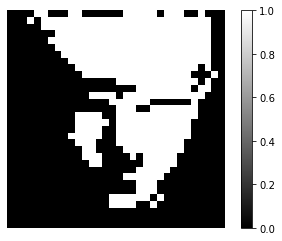

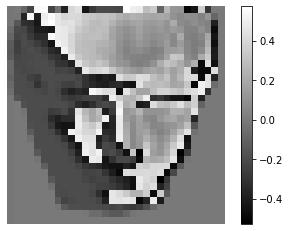

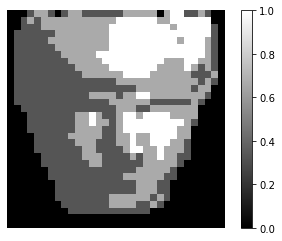

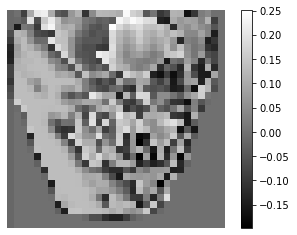

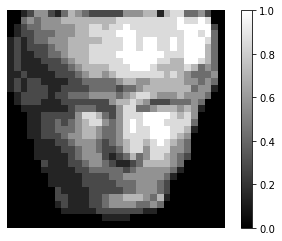

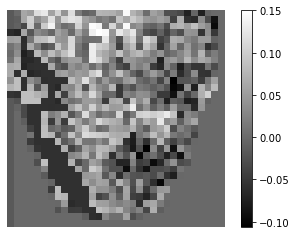

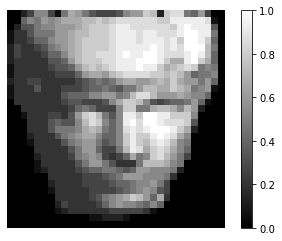

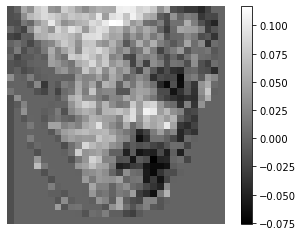

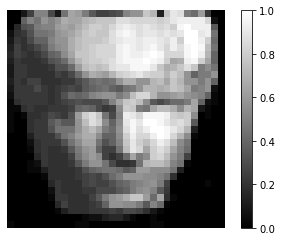

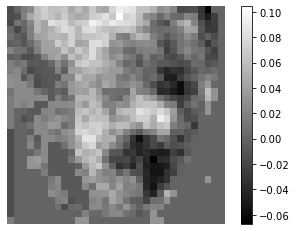

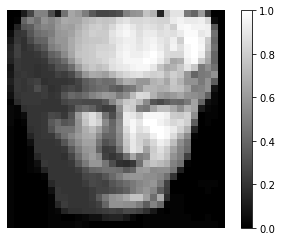

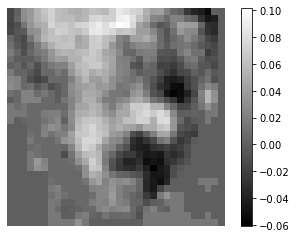

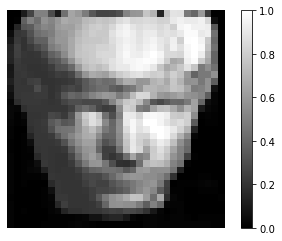

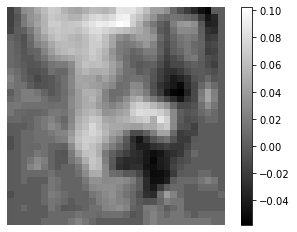

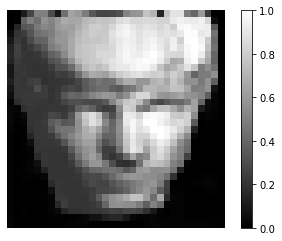

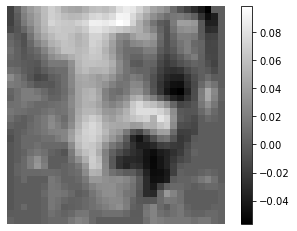

In [133]:
for bit_depth in [1, 2, 3, 4, 5, 6, 7, 8]:
    squeezer = get_squeezer(bit_depth)
    squeeze_adv_x = squeezer(target_adv_x)
    adv_squeeze_pred, _, _ = model.predict(squeeze_adv_x[:, None])
    adv_squeeze_pred_sse = np.sum((adv_squeeze_pred - target_y)**2)
    squeeze_sse = np.sum((adv_squeeze_pred - adv_pred)**2)
    print("Bit depth:{}, true sse: {}, adv sse: {}".format(bit_depth, adv_squeeze_pred_sse, squeeze_sse))
    u.plot_img(squeeze_adv_x)
    u.plot_img(squeeze_adv_x - target_x)

In [142]:
for param in [2, 3, 4, 5]:
    squeezer = get_squeezer(param, squeezer_type="median_filter")
    train_normal_sse = get_squeeze_difference(true_train_x, squeezer)
    threshold = np.quantile(train_normal_sse, 1 - fpr)
    print("filter size: {}, fpr: {}, threshold: {}".format(bit_depth, fpr, threshold))
    test_normal_sse = get_squeeze_difference(true_test_x, squeezer)
    test_adv_sse = get_squeeze_difference(adv_test_x, squeezer)
    test_normal_correct = len(np.where(test_normal_sse < threshold)[0])
    test_normal_wrong = len(np.where(test_normal_sse >= threshold)[0])

    test_adv_correct = len(np.where(test_adv_sse >= threshold)[0])
    test_adv_wrong = len(np.where(test_adv_sse < threshold)[0])

    print("Normal: correct: {}, wrong: {}".format(test_normal_correct, test_normal_wrong))
    print("Adv: correct: {}, wrong: {}".format(test_adv_correct, test_adv_wrong))
    print("")

{'squeezers': 'median_filter_2', 'distance_measure': 'l2', 'fpr': 0.05}
filter size: 4, fpr: 0.05, threshold: 0.10103544602106022
Normal: correct: 95, wrong: 5
Adv: correct: 10, wrong: 90

{'squeezers': 'median_filter_3', 'distance_measure': 'l2', 'fpr': 0.05}
filter size: 4, fpr: 0.05, threshold: 0.034879590936489985
Normal: correct: 94, wrong: 6
Adv: correct: 2, wrong: 98

{'squeezers': 'median_filter_4', 'distance_measure': 'l2', 'fpr': 0.05}
filter size: 4, fpr: 0.05, threshold: 0.13507162551406177
Normal: correct: 97, wrong: 3
Adv: correct: 5, wrong: 95

{'squeezers': 'median_filter_5', 'distance_measure': 'l2', 'fpr': 0.05}
filter size: 4, fpr: 0.05, threshold: 0.18136869203131223
Normal: correct: 94, wrong: 6
Adv: correct: 4, wrong: 96



In [179]:
# get joint score
all_train_normal_scores = np.zeros([598, 8])
all_test_normal_scores = np.zeros([100, 8])
all_test_adv_scores = np.zeros([100, 8])


for i,bit_depth in enumerate([1, 2, 3, 4, 5, 6, 7, 8]):
    squeezer = get_squeezer(bit_depth)
    train_normal_sse = get_squeeze_difference(true_train_x, squeezer)
    all_train_normal_scores[:, i] = train_normal_sse
    
    test_normal_sse = get_squeeze_difference(true_test_x, squeezer)
    all_test_normal_scores[:, i] = test_normal_sse
    
    test_adv_sse = get_squeeze_difference(adv_test_x, squeezer)
    all_test_adv_scores[:, i] = test_adv_sse
    
#     threshold = np.quantile(train_normal_sse, 1 - fpr)
#     print("Bit depth: {}, fpr: {}, threshold: {}".format(bit_depth, fpr, threshold))
    
    
#     test_adv_sse = get_squeeze_difference(adv_test_x, squeezer)
#     test_normal_correct = len(np.where(test_normal_sse < threshold)[0])
#     test_normal_wrong = len(np.where(test_normal_sse >= threshold)[0])

#     test_adv_correct = len(np.where(test_adv_sse >= threshold)[0])
#     test_adv_wrong = len(np.where(test_adv_sse < threshold)[0])

#     print("Normal: correct: {}, wrong: {}".format(test_normal_correct, test_normal_wrong))
#     print("Adv: correct: {}, wrong: {}".format(test_adv_correct, test_adv_wrong))
#     print("")

{'squeezers': 'bit_depth_1', 'distance_measure': 'l2', 'fpr': 0.05}
{'squeezers': 'bit_depth_2', 'distance_measure': 'l2', 'fpr': 0.05}
{'squeezers': 'bit_depth_3', 'distance_measure': 'l2', 'fpr': 0.05}
{'squeezers': 'bit_depth_4', 'distance_measure': 'l2', 'fpr': 0.05}
{'squeezers': 'bit_depth_5', 'distance_measure': 'l2', 'fpr': 0.05}
{'squeezers': 'bit_depth_6', 'distance_measure': 'l2', 'fpr': 0.05}
{'squeezers': 'bit_depth_7', 'distance_measure': 'l2', 'fpr': 0.05}
{'squeezers': 'bit_depth_8', 'distance_measure': 'l2', 'fpr': 0.05}


In [180]:
train_normal_joint_score = np.max(all_train_normal_scores, axis=1)
threshold = np.quantile(train_normal_joint_score, 1-fpr)
print(threshold)

0.3386713332499915


In [181]:
test_normal_joint_score = np.max(all_test_normal_scores, axis=1)
test_adv_joint_score = np.max(all_test_adv_scores, axis=1)

test_normal_correct = len(np.where(test_normal_joint_score < threshold)[0])
test_normal_wrong = len(np.where(test_normal_joint_score >= threshold)[0])

test_adv_correct = len(np.where(test_adv_joint_score >= threshold)[0])
test_adv_wrong = len(np.where(test_adv_joint_score < threshold)[0])

print("Normal: correct: {}, wrong: {}".format(test_normal_correct, test_normal_wrong))
print("Adv: correct: {}, wrong: {}".format(test_adv_correct, test_adv_wrong))

Normal: correct: 95, wrong: 5
Adv: correct: 7, wrong: 93


In [182]:
test_adv_joint_score

array([0.00847198, 0.01814767, 0.13415639, 0.03535153, 0.12765669,
       0.20768248, 0.11301157, 0.04046599, 0.03864153, 0.19789708,
       0.00240487, 0.02409474, 0.04619018, 0.00468437, 0.05372998,
       0.00560765, 0.05263123, 0.00964388, 0.00653007, 0.38018179,
       0.0037933 , 0.0158507 , 0.12249766, 0.08965938, 0.1882153 ,
       0.11532759, 0.02172118, 0.05667793, 0.07885898, 0.04213491,
       0.24349999, 0.10197512, 0.03710603, 0.03558347, 0.02138967,
       0.11618573, 0.02310413, 0.04991977, 0.05403721, 0.18842127,
       0.15169165, 0.04505714, 0.01528625, 0.0044973 , 0.0166958 ,
       0.02015726, 0.01232654, 0.05040853, 0.23682663, 0.05649434,
       0.47334809, 0.00928073, 0.02963797, 0.49382267, 0.07636087,
       0.05530322, 0.43987976, 0.01425727, 0.01320185, 1.02456747,
       0.1344461 , 0.16449621, 0.03998705, 0.01420938, 0.502755  ,
       0.10803428, 0.10243867, 0.00848412, 0.00917727, 0.00889779,
       0.06872191, 0.02628149, 0.02215005, 0.04729381, 0.02655

In [183]:
test_normal_joint_score

array([8.68004999e-03, 2.03673056e-02, 2.57823333e-01, 1.43288566e-02,
       4.22639501e-02, 8.75281367e-02, 1.41345417e-02, 2.45272370e-02,
       7.56820628e-02, 3.13966675e-01, 7.52332374e-03, 2.00452669e-02,
       3.19490677e-02, 6.31811748e-03, 2.45067806e-02, 4.14264072e-03,
       4.60346703e-02, 9.53459698e-03, 1.73838259e-02, 3.15850779e-01,
       7.94204585e-03, 5.44778653e-02, 1.31330170e-01, 3.07192488e-01,
       1.86368262e-01, 1.94435431e-01, 2.30666247e-02, 4.84046010e-02,
       2.07266183e-01, 6.83436469e-02, 3.11565205e-01, 9.75276913e-02,
       5.26629278e-02, 2.45706865e-02, 1.36065004e-02, 5.19587383e-02,
       5.56759893e-02, 4.69906642e-02, 4.10905622e-02, 6.26291790e-01,
       4.14407106e-02, 5.68337791e-02, 8.47009164e-03, 6.49490166e-04,
       3.99864718e-03, 1.69838700e-02, 6.83141121e-02, 6.62921745e-02,
       1.23842223e-01, 9.42602630e-02, 3.55009028e-01, 1.00510321e-02,
       4.16578666e-02, 1.68936797e-01, 8.75428626e-02, 8.11686541e-02,
      

In [184]:
a = np.where(test_adv_joint_score > test_normal_joint_score)

In [185]:
a


(array([ 3,  4,  5,  6,  7, 11, 12, 14, 15, 16, 17, 19, 24, 27, 31, 33, 34,
        35, 37, 38, 40, 42, 43, 44, 45, 48, 50, 53, 56, 59, 60, 62, 64, 65,
        67, 69, 70, 71, 74, 76, 78, 79, 81, 82, 83, 87, 88, 90, 91, 93, 95,
        97, 98, 99], dtype=int64),)